In [3]:
import pandas as pd
import re
import pingouin as pg
import seaborn as sns
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt

In [4]:
# история заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи
ab_users_data = pd.read_csv('ab_users_data.csv')


In [5]:
# подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ
ab_orders = pd.read_csv('ab_orders.csv')

In [6]:
# подробная информация о продуктах, их название и стоимость
ab_products = pd.read_csv('ab_products.csv')

#### 1. Иследование данных

In [7]:
ab_users_data.action.value_counts()

create_order    4123
cancel_order     214
Name: action, dtype: int64

In [8]:
ab_users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


**Датафрейм ab_users_data:**
- *user_id* - id пользователя
- *order_id* - id заказа
- *action* - статус заказа (create_order - заказ создан, cancel_order - заказ отменен)
- *time* - время создания или отмены заказа
- *date* - дата создания или отмены заказа
- *group* - принадлежность группе (0-без системы рекомендации, 1-с системой рекомендации)

In [12]:
ab_orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


**Датафрейм ab_orders:**
- *order_id* - id заказа
- *creation_time* - дата и время создания или отмены заказа
- *product_ids* - список id тех продуктов, которые были включены в заказ

In [13]:
ab_products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


**Датафрейм ab_products:**
- *product_id* - id продукта
- *name* - название продукта
- *price* - цена продукта

Посмотрим насколько у нас отличаются количество исследований 0 и 1 группы.

In [14]:
ab_users_data.groupby('group')['action', 'group'].value_counts()

C:\Users\uszai\AppData\Local\Temp\ipykernel_18296\2354096707.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ab_users_data.groupby('group')['action', 'group'].value_counts()


group  action      
0      create_order    1609
       cancel_order      82
1      create_order    2514
       cancel_order     132
dtype: int64

Процентное соотношение групп в нашем A/B тесте

In [285]:
ab_users_data.group.value_counts(normalize = True).mul(100)

1    61.009915
0    38.990085
Name: group, dtype: float64

Проверим сколько пользователей учавствовало в нашем АБ-тесте.

In [287]:
count_order = ab_users_data.groupby(['user_id', 'group']) \
    .agg({'action': 'count'}) \
    .rename(columns={'action': 'count_order'}) \
    .reset_index()
count_order.head()

,user_id,group,count_order
0,964,0,2
1,965,1,9
2,966,0,2
3,967,1,5
4,968,0,3


На сколько по модулю отличается количество наблюдений в тесте и контроле? 

In [288]:
# abs() - взять модуль
abs(count_order.query('group == 0').user_id.count() - count_order.query('group == 1').user_id.count())

13

Проверим, разница в наших выборках между группами 0 и 1 статистически не значима или нет? 
Так как p-value > 0.05, наши выборки не имеют статистически значимые различия.

In [289]:
stats.mannwhitneyu(revenue.query('group == 0').user_id.unique(), revenue.query('group == 1').user_id.unique())

MannwhitneyuResult(statistic=132348.0, pvalue=0.510403326459026)

Мы специально сгруппировали наш датафрейм по пользователям, группам и посчитали сколько заказов приходится на каждого пользователя. Потому что в контрольной группе (0) у нас *39%* заказов, а в тестовой группе *61%*, хотя размер выборок различается друг от друга статистически не значимо.

#### 2. Подготовка данных

Подготовим наши данные. 

In [16]:
# Смерджим  ab_users_data и ab_orders
merge_product_ids = ab_users_data.merge(ab_orders[['order_id', 'product_ids']], how = 'inner', on = 'order_id')
merge_product_ids.head()

,user_id,order_id,action,time,date,group,product_ids
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,"{75, 22, 53, 84}"
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,"{56, 76, 39}"
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,"{76, 34, 41, 38}"
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,"{74, 6}"
4,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0,"{74, 6}"


In [17]:
# Преобразуем нашу колонку product_ids в список для дальнейшей трансформации.
merge_product_ids['product_ids'] = merge_product_ids['product_ids'].str.replace('{|}','').str.split(',')

C:\Users\uszai\AppData\Local\Temp\ipykernel_18296\3421741937.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  merge_product_ids['product_ids'] = merge_product_ids['product_ids'].str.replace('{|}','').str.split(',')


In [20]:
# Теперь запишем для удобства колонку со списком наших продуктов как отдельную строку. 
# Тем самым сможем смерджить merge_product_ids c ab_products.
merge_product_ids = merge_product_ids.explode('product_ids')
merge_product_ids.head()

,user_id,order_id,action,time,date,group,product_ids
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,75
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,22
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,53
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,84
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,56


In [21]:
# Переименуем колонки для дальнейшего соединения датафреймов.
merge_product_ids = merge_product_ids.rename(columns = {'product_ids': 'product_id'})

In [22]:
#Приведем колонку-ключ, по которому будем объединять таблицы к нужному формату данных.
merge_product_ids['product_id'] = merge_product_ids['product_id'].astype(int)

In [23]:
# Объединим данные и получим финальный датафрейм для дальнейшего анализа.
finish_df = merge_product_ids.merge(ab_products, how = 'left', on = 'product_id')

In [24]:
finish_df.head()

,user_id,order_id,action,time,date,group,product_id,name,price
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,75,сок ананасовый,120.0
1,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,22,сок мультифрукт,120.0
2,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,53,мука,78.3
3,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,84,мандарины,90.4
4,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,56,сосиски,150.0


**Датафрейм finish_df:**
- *user_id* - id пользователя
- *order_id* - id заказа
- *action* - статус заказа (create_order - заказ создан, cancel_order - заказ отменен)
- *time* - время создания или отмены заказа
- *date* - дата создания или отмены заказа
- *group* - принадлежность группе (0-без системы рекомендации, 1-с системой рекомендации)
- *product_id* - id продукта
- *name* - название продукта
- *price* - цена продукта

#### 3. Проверка данных

Проверим наши данные на соответствие в % наших групп до объединения и после

Статистика наших групп до преобразования

In [25]:
ab_users_data.group.value_counts(normalize = True).mul(100)

1    61.009915
0    38.990085
Name: group, dtype: float64

Статистика наших групп после преобразования

In [26]:
finish_df.group.value_counts(normalize = True).mul(100)

1    61.033702
0    38.966298
Name: group, dtype: float64

Как видим данные соответствуют.

Пропущенных значений нет

In [27]:
finish_df.isnull().sum()

user_id       0
order_id      0
action        0
time          0
date          0
group         0
product_id    0
name          0
price         0
dtype: int64

#### 4. Решение задачи

*Наша задача* – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. 
Для этого нужно выбрать одну или несколько метрик, которая отвечает за качество сервиса
и статистически сравнить эти метрики в двух группах.

В качестве важной метрики для бизнеса мы можем взять
купленное *количество продуктов и  выручка.*

Чтобы сравнить выручку и количество продуктов в 2 группах, мы подготовим датафрейм, 
по каждому пользователю разделенных по группам.

In [28]:
revenue = finish_df.query('action == "create_order"') \
    .groupby(['user_id', 'group', 'date']) \
    .agg({'user_id':'count', 'price':'sum'}).rename(columns={'user_id':'count_per_user'}).reset_index()
revenue.head()

,user_id,group,date,count_per_user,price
0,964,0,2022-08-26,8,718.9
1,965,1,2022-08-26,3,250.5
2,965,1,2022-08-27,4,860.6
3,965,1,2022-08-29,14,1845.8
4,965,1,2022-09-04,12,1198.6


Посмотрим на данные с выручкой по каждому пользователю разделенных по группам. 
Видим, что за **2022-08-26** выручка в несколько раз превышает выручку по сравнению с остальными днями. 

In [310]:
revenue.groupby(['date', 'group']).agg({'price': 'sum'}).reset_index()

,date,group,price
0,2022-08-26,0,239799.3
1,2022-08-26,1,247988.4
2,2022-08-27,0,42107.8
3,2022-08-27,1,74960.2
4,2022-08-28,0,32233.6
5,2022-08-28,1,77583.2
6,2022-08-29,0,45531.8
7,2022-08-29,1,88223.2
8,2022-08-30,0,34998.4
9,2022-08-30,1,55303.3


Уберем данные за 2022-08-26, чтобы она нам не портила распределение наших выборок. 

In [29]:
revenue_per_user = revenue.query('date > "2022-08-26"') \
    .groupby(['date', 'group']) \
    .agg({'count_per_user': 'sum','price': 'sum'}) \
    .reset_index() \
    .rename(columns = {'price': 'revenue'})
revenue_per_user.head()

,date,group,count_per_user,revenue
0,2022-08-27,0,393,42107.8
1,2022-08-27,1,673,74960.2
2,2022-08-28,0,311,32233.6
3,2022-08-28,1,688,77583.2
4,2022-08-29,0,376,45531.8


*Построим боксплот*. Наглядно видно что выручка и количество покупок в тестовой группе у нас увеличилась, 
а также ее средняя намного больше контрольной.

Text(0, 0.5, 'Выручка')

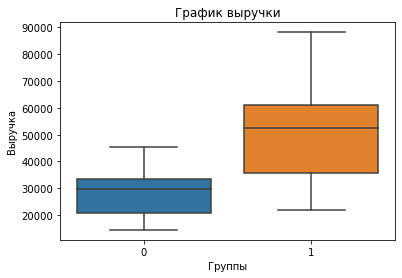

In [31]:
sns.boxplot(x="group", y="revenue", data=revenue_per_user)
plt.title('График выручки')
plt.xlabel('Группы')
plt.ylabel('Выручка')

Text(0, 0.5, 'Количество покупок')

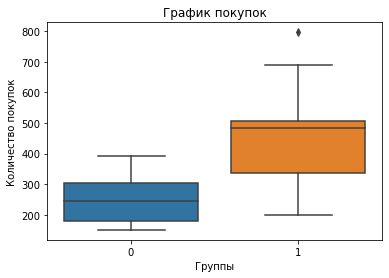

In [32]:
sns.boxplot(x="group", y="count_per_user", data=revenue_per_user)
plt.title('График покупок')
plt.xlabel('Группы')
plt.ylabel('Количество покупок')

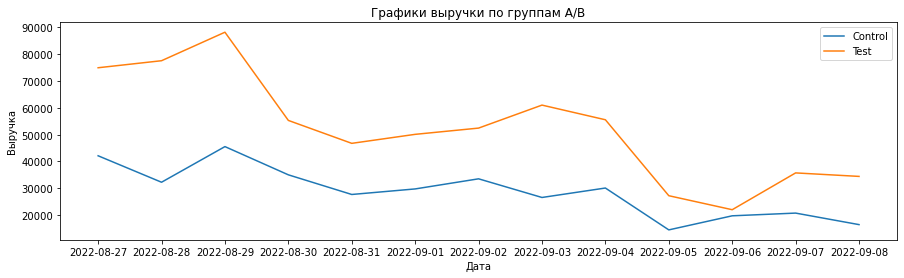

In [34]:
revenue_group_0 = revenue_per_user[revenue_per_user['group']==0]
revenue_group_1 = revenue_per_user[revenue_per_user['group']==1]
plt.figure(figsize=(15,4))
plt.plot(revenue_group_0['date'], revenue_group_0['revenue'], label = 'Control')
plt.plot(revenue_group_1['date'], revenue_group_1['revenue'], label = 'Test')
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.title('Графики выручки по группам A/B')
plt.legend()
plt.show()

**Выводы:** Как мы видим, группа Test(1) стабильно показывает большую выручку чем группа Control(0)

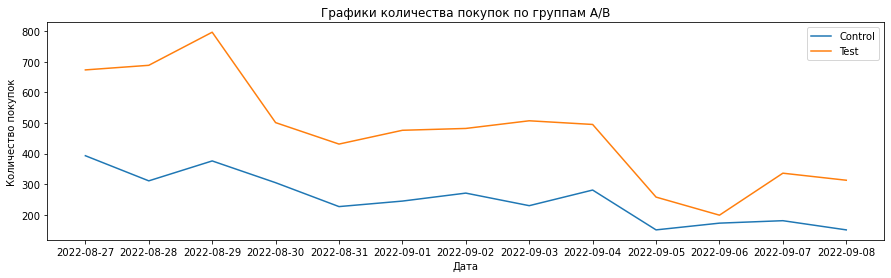

In [35]:
count_group_0 = revenue_per_user[revenue_per_user['group']==0]
count_group_1 = revenue_per_user[revenue_per_user['group']==1]
plt.figure(figsize=(15,4))
plt.plot(count_group_0['date'], count_group_0['count_per_user'], label = 'Control')
plt.plot(count_group_1['date'], count_group_1['count_per_user'], label = 'Test')
plt.ylabel('Количество покупок')
plt.xlabel('Дата')
plt.title('Графики количества покупок по группам A/B')
plt.legend()
plt.show()

**Выводы:** Как мы видим, группа Test(1) стабильно показывает больше покупок чем группа Control(0)

Сагригируем наши данные для удобства. По каждому клиенту отобразим количество сделанных покупок и суммирующую выручку.

In [39]:
count_revenue = revenue.groupby(['user_id', 'group']) \
    .agg({'count_per_user': 'sum', 'price': 'sum'}) \
    .reset_index() \
    .rename(columns={'price':'revenue'})
count_revenue.head()

,user_id,group,count_per_user,revenue
0,964,0,8,718.9
1,965,1,33,4155.5
2,966,0,2,85.0
3,967,1,18,1137.4
4,968,0,11,1590.7


Построим распределение значение выручки нашей тестовой группы:

<AxesSubplot:>

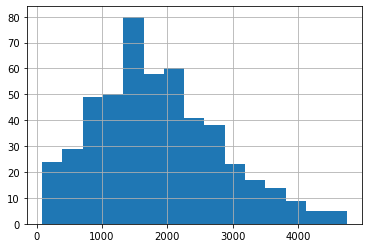

In [40]:
distr_revenue_group_1 = count_revenue.query('group == 1').revenue
distr_revenue_group_1.hist(bins=15)

Построим распределение значение выручки нашей тестовой группы, срежем выбросы для эффективности дальнейшего анализа:

<AxesSubplot:>

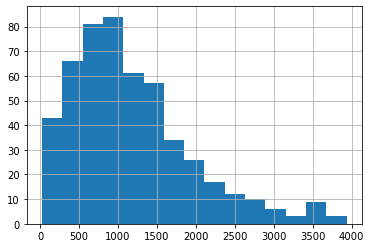

In [41]:
distr_revenue_group_0 = count_revenue.query('group == 0 and revenue < 4500').revenue
distr_revenue_group_0.hist(bins=15)

Построим распределение значение количества покупок нашей тестовой группы, срежем выбросы для эффективности дальнейшего анализа:


<AxesSubplot:>

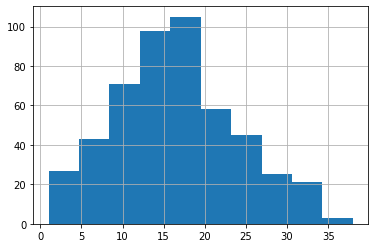

In [42]:
distr_of_purch_group_1 = count_revenue.query('group == 1 and count_per_user < 40').count_per_user
distr_of_purch_group_1.hist(bins=10)

Построим распределение значение количества покупок нашей контрольной группы, срежем выбросы для эффективности дальнейшего анализа:


<AxesSubplot:>

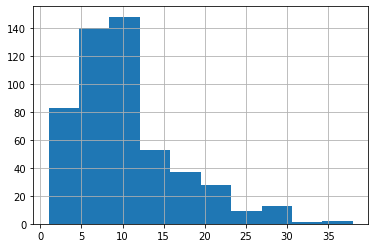

In [43]:
distr_of_purch_group_0 = count_revenue.query('group == 0 and count_per_user < 40').count_per_user
distr_of_purch_group_0.hist(bins=10)

Проверим наши распределения на нормальность (используем 2 метода): с помощью pingouin и теста Шапиро-Уилка.

Проверяем распределение выручки

In [44]:
pg.normality(data=count_revenue, dv="revenue", group="group", method="normaltest") # проверим с помощью pingouin

,W,pval,normal
group,,,
0,158.042704,4.802449e-35,False
1,21.921081,1.737392e-05,False


In [45]:
stats.shapiro(distr_revenue_group_0) # и проверим еще с помощью Шапиро-Уилка для контрольной группы, без выбросов

ShapiroResult(statistic=0.921268105506897, pvalue=1.0424476833506037e-15)

In [46]:
stats.shapiro(distr_revenue_group_1) # и для тестовой, без выбросов

ShapiroResult(statistic=0.9757506847381592, pvalue=2.1518859227853682e-07)

Поскольку наши распределения распределены ненормально, p-value < 0.05
Т-критерий Стьюдента не подойдет. Воспользуемся U-критерием Манна-Уитни:

In [47]:
stats.mannwhitneyu(distr_revenue_group_0, distr_revenue_group_1)

MannwhitneyuResult(statistic=71693.0, pvalue=3.6917754053192207e-34)

Получаем p-value < 0.05, значение сравниваемых групп статистически различны.

Проверяем распределения количества покупок:

In [48]:
pg.normality(data=count_revenue, dv="count_per_user", group="group", method="normaltest") # проверим с помощью pingouin

,W,pval,normal
group,,,
0,122.122425,3.030068e-27,False
1,30.267881,2.675551e-07,False


In [49]:
stats.shapiro(distr_of_purch_group_0) # и проверим еще с помощью Шапиро-Уилка для контрольной группы, без выбросов

ShapiroResult(statistic=0.914870023727417, pvalue=2.075311453600821e-16)

In [50]:
stats.shapiro(distr_of_purch_group_1) # и для тестовой, бех выбросов

ShapiroResult(statistic=0.9851899147033691, pvalue=6.117170414654538e-05)

Поскольку наши распределения распределены ненормально, p-value < 0.05, Т-критерий Стьюдента не подойдет. Воспользуемся U-критерием Манна-Уитни :

In [51]:
stats.mannwhitneyu(distr_of_purch_group_0, distr_of_purch_group_1)

MannwhitneyuResult(statistic=64468.5, pvalue=3.659935136139227e-42)

Получаем p-value < 0.05, значение сравниваемых групп статистически различны.

**Интерпритируем результаты:**

В этом примере U-критерий Манна-Уитни использует следующие нулевую и альтернативную гипотезы:

- H0 : выручка полученная от наших покупателей не различается
- H1 : количество покупок покупателей не различается

- H0(1) : выручка полученная от наших покупателей статистически различается
- H1(1) : вколичество покупок покупателей статистически различается

Поскольку p-значение намного меньше 0,05, мы можем отвергнуть нулевую гипотезу H0.

Это означает, что у нас достаточно доказательств, чтобы сказать, 
что истинное значение выручки различается между двумя группами.

Поскольку p-значение намного меньше 0,05, мы можем отвергнуть нулевую гипотезу H0(1).

Это означает, что у нас достаточно доказательств, чтобы сказать, 
что истинное значение количество покупок покупателями различается между двумя группами.

**Вывод:** В ходе нашей работы мы сперва группировали и агригировали наши данные, чтобы предварительно сложилась картинка о
результатах нашего АБ-теста. 
<p>На первом этапе исследования данные нам показали практически одинаковые размеры выборок,
которые различаются между собой статистически не значимо. Но тем не менее, количество заказов у группы с системой
рекомендаций было больше на 22% (61% против 39%). Далее выбрав важные метрики для нашего бизнеса - выручка и количество
покупок, мы графически изобразили данные наших групп. И снова наглядно убедились, что значения наших групп различаются
между собой. Тестовая группа (group 1) показывает стабильно выше результаты, чем контрольная групп (group 0). 
Количество покупок и размер выручки у тестовой группы каждый день был выше контрольной. 
Далее проверив наши распределения на нормальность и избавившись от выбросов, использовали U-критерий Манна-Уитни 
чтобы проверить наши данные на статистически значимые различия. 
<p>Исходя из результата теста мы РЕКОМЕНДУЕМ использовать тестовую "систему рекомендаии товаров" на всех пользователей.